# Save topic model as an ontology
* Open the trained model
* Create necessary classes and properties

see: https://owlready2.readthedocs.io/en/latest/index.html

In [1]:
import pickle
from owlready2 import *

## Load the trained model
The model was trained in notebook 01_Train_model

In [2]:
with open('../models/lda_nlp_train.pickle', 'rb') as handle:
    ldamodel = pickle.load(handle)

## Convert topics to OWL classes 

In [3]:
# get all topics in the model
topics = ldamodel.show_topics(formatted=False)

# create a new empty ontology
iri = "http://fan.zib.de/aot29/topic"
ontology = get_ontology(f"{iri}.owl")

#################
#   datatypes   #
#################

class WordProbability:
    def __init__(self, word, probability):
        self.word = word
        self.probability = probability

def wp_parser(s):
    splits = s.split(',')
    word = splits[0].strip()
    probability = float(splits[1].strip())
    return(WordProbability(word, probability))
    
def wp_unparser(x):
    return (f"('{x.word}', {x.probability})")    

declare_datatype(WordProbability, f"{iri}#WordProbability", wp_parser, wp_unparser)

with ontology:

    #################
    #    classes    #
    #################
    
    class Topic(Thing):
        pass

    class has_parent(ObjectProperty):
        domain = [Topic]
        range = [Topic]

    class topic_id(DataProperty, FunctionalProperty):
        domain = [Topic]
        range = [int]

    class label(DataProperty, FunctionalProperty):
        domain = [Topic]
        range = [str]

    class word_probabilities(DataProperty):
        domain = [Topic]
        range = [WordProbability]
    
    #################
    #   instances   #
    #################
    
    # the base topic instance for all topics is NLP
    base_topic = Topic("NLP")
    
    for topic in topics:
        topic_id = topic[0]
        name = f"Topic-{topic_id}"
        label = str([topic[1][i][0] for i in range(0, 3)])  # use the first 3 words as the label
        word_probabilities = str(topic[1])
        new_topic = Topic(name, has_parent=[base_topic], topic_id=topic_id, label=label, word_probabilities=[word_probabilities])
    

In [4]:
ontology.save(file='../data/topics.owl', format='rdfxml')

Following code generated by ChatGPT

In [1]:
import rdflib
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
# Load the OWL file
g = rdflib.Graph()
g.parse("../data/topics.owl", format="xml")

<Graph identifier=N957f649f65bf49599fb79ae72105964f (<class 'rdflib.graph.Graph'>)>

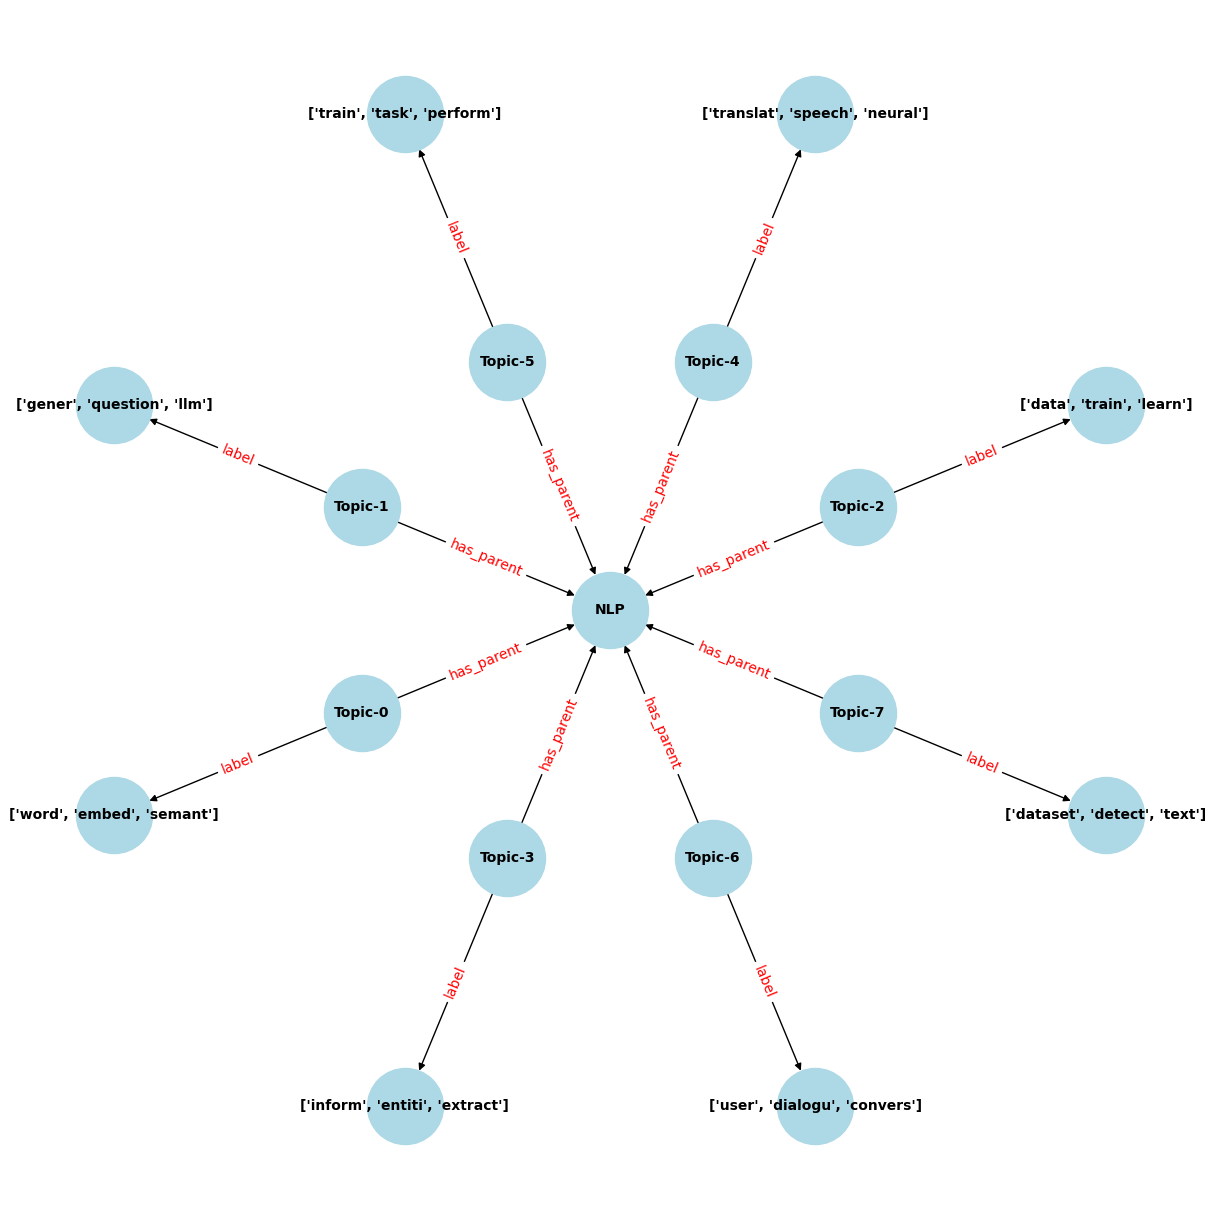

In [40]:
# Create a NetworkX graph
G = nx.DiGraph()
max_label_len = 10

filter = ['word_probabilities', 'topic_id', 'domain', 'range', 'Thing', 'Class', 'NamedIndividual', 'type']
def filter_out(subj, pred, obj):
    found = False
    for term in filter:
        if (term in subj) or (term in pred) or (term in obj):
            found = True
            break
    return found

def parse_label(raw):
    raw = str(raw)
    resp = raw
    if '#' in raw:
        resp = raw.split('#')[1]
    return resp

# Extract and add triples to the NetworkX graph
for subj, pred, obj in g:
    if filter_out(subj, pred, obj): continue    
    subj_label = parse_label(subj)
    pred_label = parse_label(pred)
    obj_label = parse_label(obj)
    
    G.add_edge(subj_label, obj_label, label=pred_label)

# Draw the graph
pos = graphviz_layout(G, prog="twopi")
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)

# Draw edge labels
edge_labels = {(n1, n2): d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.show()